# Прогнозирование цен на жилье - задача регрессии

Простой, но сложный проект для прогнозирования цены на жилье на основе определенных факторов, таких как площадь дома, спальни, меблировка, близость к главной дороге и т.д. Набор данных пока небольшой, его сложность возникает из-за того, что он обладает сильной мультиколлинеарностью.  

Оценка стоимости жилья полезна для всех участников рынка недвижимости, включая покупателей, продавцов, инвесторов, риелторов и финансовые учреждения.

## О наборе данных

| Признак на английском | Перевод на русский | Расшифровка на русском |
|---|---|---|
| area | площадь | площадь дома в квадратных футах |
| bedrooms | спальни | количество спален в доме |
| bathrooms | ванные комнаты | количество ванных комнат в доме |
| stories | этажи | количество этажей в доме |
| mainroad | главная дорога | находится ли дом на главной дороге (1) или нет (0) |
| guestroom | гостевая комната | есть ли в доме гостевая комната (1) или нет (0) |
| basement | подвал | есть ли в доме подвал (1) или нет (0) |
| hotwaterheating | горячее водоснабжение | есть ли в доме горячее водоснабжение (1) или нет (0) |
| airconditioning | кондиционер | есть ли в доме кондиционер (1) или нет (0) |
| parking | парковка | есть ли у дома парковка (1) или нет (0) |
| prefarea | предпочтительный район | находится ли дом в предпочитаемом районе (1) или нет (0) |
| furnishingstatus | состояние мебели | состояние мебели в доме (без мебели, с мебелью) |

**Target variable (целевая переменная): price (цена жилья)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the Dataset

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/Housing.csv')
data

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [ ]:
data.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [ ]:
data.describe(include="object")

,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus
count,545,545,545,545,545,545,545
unique,2,2,2,2,2,2,3
top,yes,no,no,no,no,no,semi-furnished
freq,468,448,354,520,373,417,227


 # Data preprocessing

In [ ]:
# Создадим словарь для сопоставления категориальных значений с числовыми значениями.
mapping = {
    "yes": 1,
    "no": 0,
}

# Используем словарь для замены категориальных значений на числовые значения.
data["mainroad"] = data["mainroad"].map(mapping)
data["guestroom"] = data["guestroom"].map(mapping)
data["basement"] = data["basement"].map(mapping)
data["hotwaterheating"] = data["hotwaterheating"].map(mapping)
data["airconditioning"] = data["airconditioning"].map(mapping)
data["prefarea"] = data["prefarea"].map(mapping)

In [ ]:
unique_values = data["furnishingstatus"].unique()
unique_values

array(['furnished', 'semi-furnished', 'unfurnished'], dtype=object)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

le.fit(data["furnishingstatus"])

data["furnishingstatus"] = le.transform(data["furnishingstatus"])

In [ ]:
data

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,1,0,1,0,0,2,0,2
541,1767150,2400,3,1,1,0,0,0,0,0,0,0,1
542,1750000,3620,2,1,1,1,0,0,0,0,0,0,2
543,1750000,2910,3,1,1,0,0,0,0,0,0,0,0


# Exploratory Data Analysis (EDA)

In [ ]:
data.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

In [ ]:
data.corr() # корреляционная матрица (по умолчанию по Пирсону)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
price,1.000000,0.535997,0.366494,0.517545,0.420712,0.296898,0.255517,0.187057,0.093073,0.452954,0.384394,0.329777,-0.304721
area,0.535997,1.000000,0.151858,0.193820,0.083996,0.288874,0.140297,0.047417,-0.009229,0.222393,0.352980,0.234779,-0.171445
bedrooms,0.366494,0.151858,1.000000,0.373930,0.408564,-0.012033,0.080549,0.097312,0.046049,0.160603,0.139270,0.079023,-0.123244
bathrooms,0.517545,0.193820,0.373930,1.000000,0.326165,0.042398,0.126469,0.102106,0.067159,0.186915,0.177496,0.063472,-0.143559
stories,0.420712,0.083996,0.408564,0.326165,1.000000,0.121706,0.043538,-0.172394,0.018847,0.293602,0.045547,0.044425,-0.104672
mainroad,0.296898,0.288874,-0.012033,0.042398,0.121706,1.000000,0.092337,0.044002,-0.011781,0.105423,0.204433,0.199876,-0.156726
guestroom,0.255517,0.140297,0.080549,0.126469,0.043538,0.092337,1.000000,0.372066,-0.010308,0.138179,0.037466,0.160897,-0.118328
basement,0.187057,0.047417,0.097312,0.102106,-0.172394,0.044002,0.372066,1.000000,0.004385,0.047341,0.051497,0.228083,-0.112831
hotwaterheating,0.093073,-0.009229,0.046049,0.067159,0.018847,-0.011781,-0.010308,0.004385,1.000000,-0.130023,0.067864,-0.059411,-0.031628
airconditioning,0.452954,0.222393,0.160603,0.186915,0.293602,0.105423,0.138179,0.047341,-0.130023,1.000000,0.159173,0.117382,-0.150477


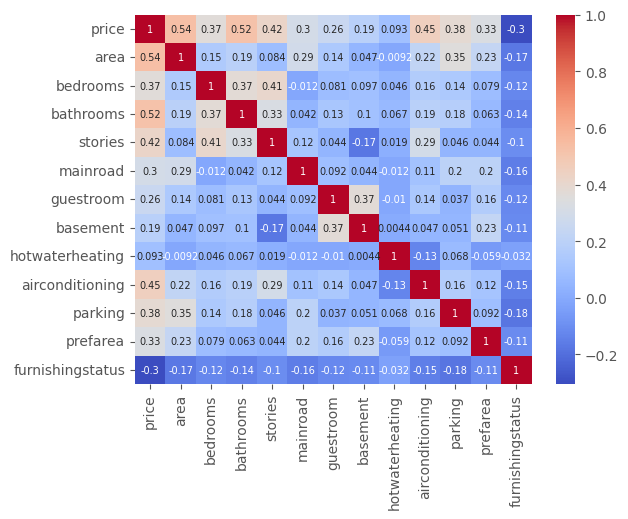

In [ ]:
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", annot_kws={"size": 7})

plt.show()

Из построения корреляционной матрицы видим, что меньше всего влияния на целевую переменную оказывают 3 признака: guestroom, basement, hotwaterheating. Попробуем использовать все признаки кроме этих 3-ёх признаков для построения регрессионной модели K ближайших соседей.

# Model Train and Predict


# Построение регрессионной модели K ближайших соседей с использованием всех признаков кроме 3-ёх наименее значимых

In [ ]:
X = data.drop(columns=['guestroom', 'basement', 'hotwaterheating','price'])
y = data['price']

## Библиотека функций

### №1 Функция для подсчета метрик качества регрессионной модели K ближайших соседей

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split

def evaluate_regression_model(model_name, X_train, y_train, y_test, y_pred):
    """
    Функция для подсчета метрик качества модели регрессии.

    Параметры:
    model_name : str
        Название модели.
    X_train : array-like
        Матрица признаков для тренировочных данных.
    y_train : array-like
        Настоящие значения целевой переменной для тренировочных данных.
    y_test : array-like
        Настоящие значения целевой переменной для тестовых данных.
    y_pred : array-like
        Предсказанные значения целевой переменной для тестовых данных.

    Возвращает:
    metrics : dict
        Словарь с названием модели, а также метрик и их значениями.
    """
    metrics = {}
    metrics['Model'] = model_name

    # Считаем метрики для тренировочных данных
    r2_train = r2_score(y_test, y_pred)

    # Считаем метрики для тестовых данных
    mse_test = mean_squared_error(y_test, y_pred)
    mae_test = mean_absolute_error(y_test, y_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

    # Добавляем метрики в словарь
    metrics['Train R^2 Score'] = r2_train
    metrics['Test Mean Squared Error'] = mse_test
    metrics['Test Mean Absolute Error'] = mae_test
    metrics['Test Mean Absolute Percentage Error'] = mape_test
    metrics['Test Root Mean Squared Error'] = rmse_test

    return metrics

### №2 Функция разбиения на контроль данных с возможностью нормализации данных для регрессионной модели K ближайших соседей

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler


def split_and_normalize_data(X, y, test_size=0.3, normalization='none', random_state=None):
    """
    Функция для разбиения на контрольные данные с возможностью нормализации.

    Параметры:
    X : array-like
        Матрица признаков.
    y : array-like
        Вектор целевой переменной.
    test_size : float, optional (default=0.3)
        Размер тестового набора данных.
    normalization : str, optional (default='none')
        Тип нормализации ('none', 'standard', 'minmax').
    random_state : int or None, optional (default=None)
        Случайное начальное значение для воспроизводимости.

    Возвращает:
    X_train : array-like
        Матрица признаков для тренировочных данных.
    X_test : array-like
        Матрица признаков для тестовых данных.
    y_train : array-like
        Вектор целевой переменной для тренировочных данных.
    y_test : array-like
        Вектор целевой переменной для тестовых данных.
    """

    # Разбиваем данные на тренировочные и тестовые
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Нормализуем данные, если указано
    if normalization == 'standard':
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)
    elif normalization == 'minmax':
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)

    return X_train, X_test, y_train, y_test

### №3 Функция для кросс-валидации регрессионной модели K ближайших соседей

In [ ]:
from sklearn.model_selection import cross_val_score

def cross_validate_model(X_train, y_train, n_neighbors, cv=5):
    """
    Функция для кросс-валидации регрессионной модели K ближайших соседей.

    Параметры:
    X_train : array-like
        Матрица признаков для тренировочных данных.
    y_train : array-like
        Вектор целевой переменной для тренировочных данных.
    n_neighbors : int
        Количество соседей для модели K ближайших соседей.
    cv : int, optional (default=5)
        Количество разбиений для перекрестной проверки.

    Возвращает:
    mean_r2 : float
        Среднее значение коэффициента детерминации R^2 по всем фолдам.
    """
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    r2_scores = cross_val_score(knn, X_train, y_train, cv=cv, scoring='r2')
    mean_r2 = np.mean(r2_scores)
    return mean_r2

### №4 Функция для определения оптимального количества соседей

In [ ]:
def find_optimal_neighbors(X_train, y_train, max_neighbors=25, cv=5):
    """
    Функция для определения оптимального количества соседей в модели K ближайших соседей.

    Параметры:
    X_train : array-like
        Матрица признаков для тренировочных данных.
    y_train : array-like
        Вектор целевой переменной для тренировочных данных.
    max_neighbors : int, optional (default=25)
        Максимальное количество соседей для проверки.
    cv : int, optional (default=5)
        Количество разбиений для перекрестной проверки.

    Возвращает:
    optimal_neighbors : int
        Оптимальное количество соседей.
    """
    # Создаем список для сохранения средних оценок для каждого значения количества соседей
    cv_scores = []

    # Пробегаемся по разным значениям количества соседей и оцениваем качество модели для каждого
    for n in range(1, max_neighbors + 1):
        mean_r2 = cross_validate_model(X_train, y_train, n, cv)
        cv_scores.append(mean_r2)

    # Находим оптимальное количество соседей, которое дает наилучший результат
    optimal_neighbors = np.argmax(cv_scores) + 1

    return optimal_neighbors

## Разбиение на контроль и масштабирование данных

In [ ]:
X_train_1, X_test_1, y_train_1, y_test_1 = split_and_normalize_data(X, y, test_size=0.3, normalization='standard', random_state=42)

## Поиск оптимального количества соседей

In [ ]:
optimal_n_neighbors_1 = find_optimal_neighbors(X_train_1, y_train_1, max_neighbors=25, cv=5)
print(f"Оптимальное количество соседей: {optimal_n_neighbors_1}")

Оптимальное количество соседей: 11


In [ ]:
neigh_1 = KNeighborsRegressor(n_neighbors=optimal_n_neighbors_1, p=2, metric = 'euclidean')
neigh_1.fit(X_train_1, y_train_1)

KNeighborsRegressor(metric='euclidean', n_neighbors=11)

In [ ]:
neigh_1.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'euclidean',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 11,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
y_pred_1 = neigh_1.predict(X_test_1)

In [ ]:
# Создаем DataFrame с предсказанными и истинными значениями
predictions_df = pd.DataFrame({'Prediction': y_pred_1,
                               'Y_true': y_test_1})

# Устанавливаем опцию форматирования для вывода чисел без экспоненциальной записи
pd.set_option('display.float_format', lambda x: '%.0f' % x)

# Выводим DataFrame
print(predictions_df)

     Prediction   Y_true
316     3607545  4060000
77      7380545  6650000
360     4000182  3710000
90      4416364  6440000
493     3860818  2800000
..          ...      ...
395     3766636  3500000
425     4107727  3360000
195     5369636  4970000
452     5277364  3150000
154     5835455  5530000

[164 rows x 2 columns]


# Построение регрессионной модели K ближайших соседей с использованием всех признаков

In [ ]:
X = data.drop(columns=['price'])
y = data['price']

## Разбиение на контроль и масштабирование данных

In [ ]:
X_train_2, X_test_2, y_train_2, y_test_2 = split_and_normalize_data(X, y, test_size=0.3, normalization='standard', random_state=42)

## Поиск оптимального количества соседей

In [ ]:
optimal_n_neighbors_2 = find_optimal_neighbors(X_train_2, y_train_2, max_neighbors=25, cv=5)
print(f"Оптимальное количество соседей: {optimal_n_neighbors_2}")

Оптимальное количество соседей: 6


### Метрика euclidean

In [ ]:
neigh_2 = KNeighborsRegressor(n_neighbors=optimal_n_neighbors_2, p=2, metric = 'euclidean')
neigh_2.fit(X_train_2, y_train_2)

KNeighborsRegressor(metric='euclidean', n_neighbors=6)

In [ ]:
neigh_2.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'euclidean',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 6,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
y_pred_2 = neigh_2.predict(X_test_2)

In [ ]:
# Создаем DataFrame с предсказанными и истинными значениями
predictions_df = pd.DataFrame({'Prediction': y_pred_2,
                               'Y_true': y_test_2})

# Устанавливаем опцию форматирования для вывода чисел без экспоненциальной записи
pd.set_option('display.float_format', lambda x: '%.0f' % x)

# Выводим DataFrame
print(predictions_df)

     Prediction   Y_true
316     4036667  4060000
77      7634667  6650000
360     3599167  3710000
90      4539500  6440000
493     3360000  2800000
..          ...      ...
395     3619583  3500000
425     4667833  3360000
195     5007333  4970000
452     4973500  3150000
154     4678333  5530000

[164 rows x 2 columns]


### Метрика manhattan

In [ ]:
neigh_3 = KNeighborsRegressor(n_neighbors=optimal_n_neighbors_2, p=2, metric = 'manhattan')
neigh_3.fit(X_train_2, y_train_2)

KNeighborsRegressor(metric='manhattan', n_neighbors=6)

In [ ]:
neigh_3.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'manhattan',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 6,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
y_pred_3 = neigh_3.predict(X_test_2)

In [ ]:
# Создаем DataFrame с предсказанными и истинными значениями
predictions_df = pd.DataFrame({'Prediction': y_pred_3,
                               'Y_true': y_test_2})

# Устанавливаем опцию форматирования для вывода чисел без экспоненциальной записи
pd.set_option('display.float_format', lambda x: '%.0f' % x)

# Выводим DataFrame
print(predictions_df)

     Prediction   Y_true
316     4362167  4060000
77      7395500  6650000
360     3634167  3710000
90      4305000  6440000
493     3640000  2800000
..          ...      ...
395     3089333  3500000
425     4440333  3360000
195     5007333  4970000
452     4956000  3150000
154     4678333  5530000

[164 rows x 2 columns]


# Model Evaluation

## Оценка качества регрессионной модели K ближайших соседей с использованием всех признаков кроме 3-ёх наименее значимых

In [ ]:
# Оценка качества модели с помощью кросс-валидации
mean_r2 = cross_validate_model(X_train_1, y_train_1, optimal_n_neighbors_1)
print("Средний коэффициент детерминации (R^2) на кросс-валидации:", mean_r2)

Средний коэффициент детерминации (R^2) на кросс-валидации: 0.5682117502980061


In [ ]:
print('Коэффициент детерминации = ', neigh_1.score(X_train_1, y_train_1))

Коэффициент детерминации =  0.6566171296183148


In [ ]:
model_name_1 = "KNN_all_without_3_Regression_Model"
model_metrics_1 = evaluate_regression_model(model_name_1, X_train_1, y_train_1, y_test_1, y_pred_1)
for metric, value in model_metrics_1.items():
    print(f"{metric}: {value}")

Model: KNN_all_without_3_Regression_Model
Train R^2 Score: 0.5748017182071907
Test Mean Squared Error: 1831070144065.5564
Test Mean Absolute Error: 950780.0831485587
Test Mean Absolute Percentage Error: 0.21537814749195458
Test Root Mean Squared Error: 1353170.404666595


## Оценка качества регрессионной модели K ближайших соседей с использованием всех признаков, метрика euclidean

In [ ]:
# Оценка качества модели с помощью кросс-валидации
mean_r2 = cross_validate_model(X_train_2, y_train_2, optimal_n_neighbors_2)
print("Средний коэффициент детерминации (R^2) на кросс-валидации:", mean_r2)

Средний коэффициент детерминации (R^2) на кросс-валидации: 0.5997825258725181


In [ ]:
print('Коэффициент детерминации = ', neigh_2.score(X_train_2, y_train_2))

Коэффициент детерминации =  0.7227469477001098


In [ ]:
model_name_2 = "KNN_all_Regression_Model_euclidean"
model_metrics_2 = evaluate_regression_model(model_name_2, X_train_2, y_train_2, y_test_2, y_pred_2)
for metric, value in model_metrics_2.items():
    print(f"{metric}: {value}")

Model: KNN_all_Regression_Model_euclidean
Train R^2 Score: 0.5722162226610858
Test Mean Squared Error: 1842204299363.9397
Test Mean Absolute Error: 948297.8963414634
Test Mean Absolute Percentage Error: 0.21114080279355
Test Root Mean Squared Error: 1357278.2689500116


## Оценка качества регрессионной модели K ближайших соседей с использованием всех признаков, метрика manhattan

In [ ]:
print('Коэффициент детерминации = ', neigh_3.score(X_train_2, y_train_2))

Коэффициент детерминации =  0.7029756723730594


In [ ]:
model_name_3 = "KNN_all_Regression_Model_manhattan"
model_metrics_3 = evaluate_regression_model(model_name_3, X_train_2, y_train_2, y_test_2, y_pred_3)
for metric, value in model_metrics_3.items():
    print(f"{metric}: {value}")

Model: KNN_all_Regression_Model_manhattan
Train R^2 Score: 0.619528094474066
Test Mean Squared Error: 1638460870365.752
Test Mean Absolute Error: 897883.7398373983
Test Mean Absolute Percentage Error: 0.2023528673244907
Test Root Mean Squared Error: 1280023.7772657787


In [ ]:
# Отфильтруем первый словарь метрик, исключив первый элемент
model_metrics_1_filtered = {key: value for key, value in model_metrics_1.items() if key != 'Model'}

# Отфильтруем второй словарь метрик, исключив первый элемент
model_metrics_2_filtered = {key: value for key, value in model_metrics_2.items() if key != 'Model'}

# Отфильтруем второй словарь метрик, исключив первый элемент
model_metrics_3_filtered = {key: value for key, value in model_metrics_3.items() if key != 'Model'}

# Создание DataFrame
df = pd.DataFrame({
    model_name_1: model_metrics_1_filtered,
    model_name_2: model_metrics_2_filtered,
    model_name_3: model_metrics_3_filtered
})

# Функция для форматирования значений
def format_values(value):
    if isinstance(value, float):
        return "{:.8f}".format(value)
    else:
        return value

# Применение функции к каждому элементу DataFrame
df = df.applymap(format_values)

# Вывод DataFrame как красивой таблицы
display(df)

,KNN_all_without_3_Regression_Model,KNN_all_Regression_Model_euclidean,KNN_all_Regression_Model_manhattan
Train R^2 Score,0.57480172,0.57221622,0.61952809
Test Mean Squared Error,1831070144065.55639648,1842204299363.93969727,1638460870365.75195312
Test Mean Absolute Error,950780.08314856,948297.89634146,897883.73983740
Test Mean Absolute Percentage Error,0.21537815,0.21114080,0.20235287
Test Root Mean Squared Error,1353170.40466659,1357278.26895001,1280023.77726578


## Вывод: лучшей моделью по метрикам качества оказалась             регрессионная модель K ближайших соседей с использованием всех признаков и метрики manhattan